In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense

from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [13]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-11-26 09:18:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.002s  

2020-11-26 09:18:55 (39.4 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [20]:
inp = Input((max_sequence_len-1,))
X = Embedding(total_words, 100, input_length=max_sequence_len-1)(inp)
X = Bidirectional(LSTM(150))(X)
out = Dense(total_words, activation='softmax')(X)
adam = Adam(0.01)
model = Model(inp, out)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


Model: "functional_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300)               301200    
_________________________________________________________________
dense_2 (Dense)              (None, 3211)              966511    
Total params: 1,588,811
Trainable params: 1,588,811
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 8s 17ms/step - loss: 6.7794 - accuracy: 0.0332
Epoch 2/100
484/484 [==============================] - 8s 17ms/step - loss: 6.0922 - accuracy: 0.0570
Epoch 3/100
484/484 [==============================] - 8s 17ms/step - loss: 5.4015 - accuracy: 0.0879
Epoch 4/100
484/484 [==============================] - 8s 17ms/step - loss: 4.6068 - accuracy: 0.1376
Epoch 5/100
484/484 [==============================] - 8s 17ms/step - loss: 3.7685 - accuracy: 0.2228
Epoch 6/100
484/484 [==============================] - 8s 17ms/step - loss: 3.0709 - accuracy: 0.3326
Epoch 7/100
484/484 [==============================] - 8s 17ms/step - loss: 2.5094 - accuracy: 0.4297
Epoch 8/100
484/484 [==============================] - 8s 17ms/step - loss: 2.1345 - accuracy: 0.5033
Epoch 9/100
484/484 [==============================] - 8s 17ms/step - loss: 1.8533 - accuracy: 0.5601
Epoch 10/100
484/484 [==============================] - 8s 17ms/step - loss: 1.646

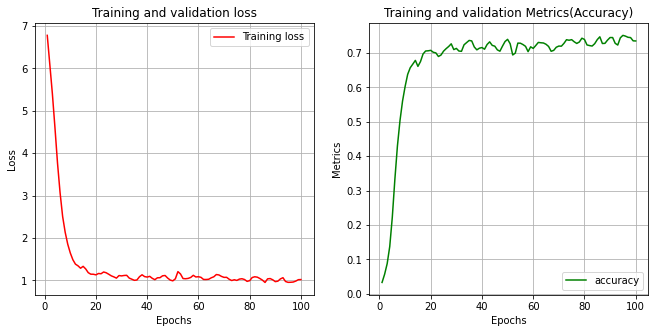

In [23]:
import matplotlib.pyplot as plt
def hs_plot(history):
    ''' history plot '''
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    #val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    ax[0].plot(epochs, loss, color='red', label='Training loss')
    #ax[0].plot(epochs, val_loss, color='deeppink', label='Validation loss')
    ax[1].plot(epochs, accuracy, color='green', label='accuracy')
    #ax[1].plot(epochs, val_accuracy, color='lime', label='val_accurace')
    ax[0].set_title('Training and validation loss')
    ax[1].set_title('Training and validation Metrics(Accuracy)')
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Metrics')
    ax[0].grid()
    ax[1].grid()
    ax[0].legend()
    ax[1].legend()
    plt.savefig('hist.png')
    plt.show()
  
hs_plot(history)

In [25]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

ValueError: ignored